In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features, build_meta_raw_returns
from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting

from phase_2.scripts.strategies.portfolio.portfolio_constructor_v1 import (
    align_asset_returns,
    compute_inverse_vol_weights,
    build_portfolio_raw_returns,
)

In [2]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    df = pd.read_parquet(f"../data/processed/{sym.lower()}_daily.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df


In [3]:
portfolio_yearly = []
portfolio_daily_all = []

years = sorted(data["SPY"]["year"].unique())  # anchor on SPY years

for test_year in years:
    # -------------------------------
    # 0. Per-asset meta outputs for this year
    # -------------------------------
    asset_daily = {}

    for sym, df in data.items():
        train = df[df["year"] < test_year].copy()
        test  = df[df["year"] == test_year].copy()

        if len(train) < 500 or len(test) == 0:
            continue

        trend_out = run_trend_strategy_v1(test, train_df=train)
        meanrev_out = run_meanrev_strategy_v1(test)

        regime = build_regime_features(test)
        meta = build_meta_raw_returns(trend_out, meanrev_out, regime)

        meta["asset"] = sym
        meta["year"] = test_year

        asset_daily[sym] = meta

    # Skip year if not all assets available
    if len(asset_daily) != len(ASSETS):
        continue

    # -------------------------------
    # 1. Align asset returns for the year (meta_raw_ret only)
    # -------------------------------
    ret_wide = align_asset_returns(asset_daily)

    # -------------------------------
    # 2. Compute equal-vol weights from meta_raw_ret
    # -------------------------------
    w = compute_inverse_vol_weights(ret_wide, lookback=20, max_weight=0.70)

    # -------------------------------
    # 3. Portfolio raw returns (pre vol targeting)
    # -------------------------------
    port_raw = build_portfolio_raw_returns(ret_wide, w)

    # -------------------------------
    # 4. Portfolio-level vol targeting
    # -------------------------------
    vt = apply_vol_targeting(port_raw, target_vol_annual=0.10, lookback=20, max_leverage=1.0)
    port = pd.DataFrame({
        "date": port_raw.index,
        "portfolio_raw_ret": port_raw.values,
        "portfolio_lev": vt["lev"].values,
        "portfolio_ret": vt["meta_ret"].values,
        "year": test_year,
    })

    portfolio_daily_all.append(port)


In [4]:
portfolio_daily = pd.concat(portfolio_daily_all).sort_values("date").reset_index(drop=True)
portfolio_daily.head()


,date,portfolio_raw_ret,portfolio_lev,portfolio_ret,year
0,2012-01-03,0.0,0.0,0.0,2012
1,2012-01-04,0.0,0.0,0.0,2012
2,2012-01-05,0.0,0.0,0.0,2012
3,2012-01-06,0.0,0.0,0.0,2012
4,2012-01-09,0.0,0.0,0.0,2012


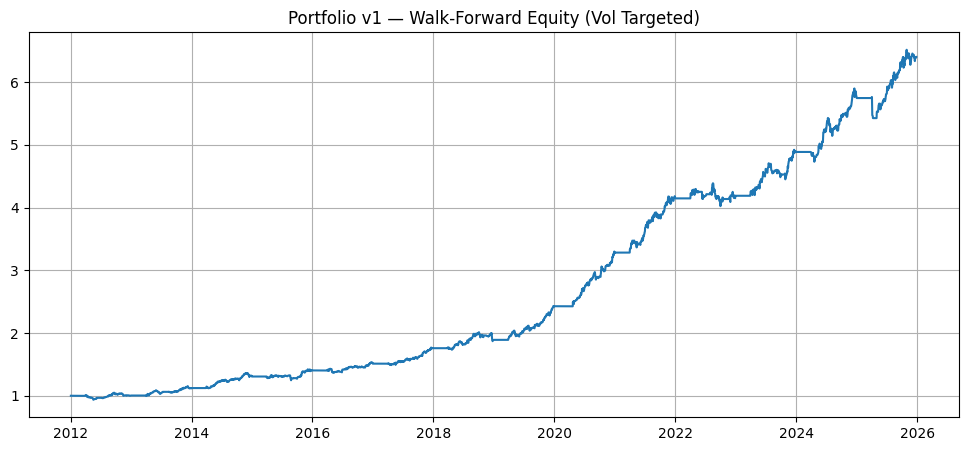

In [5]:
equity = (1 + portfolio_daily["portfolio_ret"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(portfolio_daily["date"], equity)
plt.title("Portfolio v1 — Walk-Forward Equity (Vol Targeted)")
plt.grid(True)
plt.show()


In [6]:
def sharpe_ratio(x):
    x = np.asarray(x, dtype=float)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(x) / np.nanstd(x)

def max_drawdown(equity):
    equity = np.asarray(equity, dtype=float)
    peak = np.maximum.accumulate(equity)
    dd = equity / peak - 1.0
    return np.nanmin(dd)

year_rows = []
for y, g in portfolio_daily.groupby("year"):
    eq = (1 + g["portfolio_ret"]).cumprod().values
    year_rows.append({
        "year": y,
        "sharpe": sharpe_ratio(g["portfolio_ret"].values),
        "total_return": eq[-1] - 1.0,
        "max_drawdown": max_drawdown(eq),
        "avg_leverage": g["portfolio_lev"].mean(),
    })

portfolio_summary = pd.DataFrame(year_rows).sort_values("year").reset_index(drop=True)
portfolio_summary


,year,sharpe,total_return,max_drawdown,avg_leverage
0,2012,0.090803,0.003685,-0.074653,0.913017
1,2013,1.824954,0.118500,-0.051908,0.915139
2,2014,2.280463,0.164093,-0.046283,0.923692
3,2015,0.970831,0.074356,-0.061157,0.841492
4,2016,1.300919,0.076928,-0.044050,0.920694
5,2017,2.350257,0.162996,-0.023836,0.919217
6,2018,0.945551,0.075608,-0.071036,0.875607
7,2019,3.309621,0.283573,-0.046818,0.859344
8,2020,3.502302,0.352172,-0.040400,0.702571
9,2021,2.759647,0.263450,-0.031695,0.848065


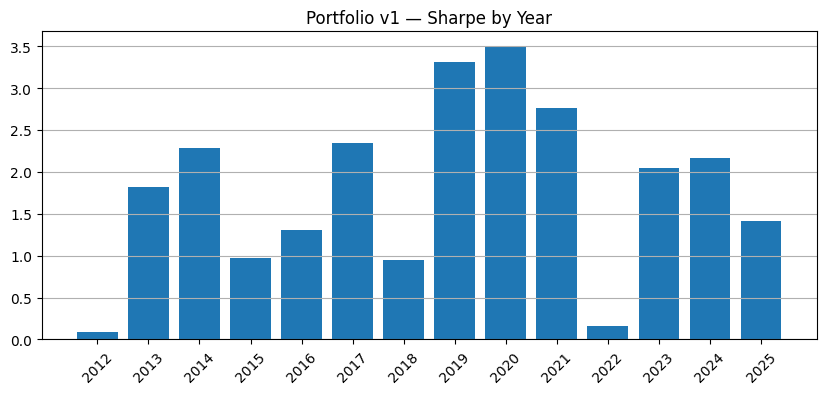

In [7]:
plt.figure(figsize=(10,4))
plt.bar(portfolio_summary["year"].astype(str), portfolio_summary["sharpe"])
plt.title("Portfolio v1 — Sharpe by Year")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.show()
